In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from scipy.io import loadmat

Using TensorFlow backend.


In [2]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [3]:
data = data.reshape((181,256,256,1))

In [4]:
label = loadmat('cl_label.mat')['cl_label']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2)

In [6]:
print('Training: ',X_train.shape)

Training:  (144, 256, 256, 1)


In [7]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [8]:
from keras.models import Sequential

In [9]:
def get_nn_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size = (4,4), strides=None,input_shape=(256,256,1)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [10]:
def get_cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), padding='same',input_shape=(256,256,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [11]:
cnn_model = get_cnn_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
nn_model = get_nn_model()

In [13]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2097664   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
__________

In [14]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
__________

In [15]:
from keras.preprocessing.image import ImageDataGenerator 

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [17]:
from keras import backend as K

In [22]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [19]:
def train_cnn_model(model):
    filepath='../opt/jaffe-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 50
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [20]:
def train_nn_model(model):
    filepath='../opt/jaffe-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 50
    model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [21]:
cnn_history, cnn_model = train_cnn_model(cnn_model)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
5/4 [=================================] - 10s 2s/step - loss: 2.9680 - fbeta: 0.0868 - acc: 0.1632 - val_loss: 8.0465 - val_fbeta: 0.2432 - val_acc: 0.2432

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.2432.hdf5

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.2432.hdf5
Epoch 2/50
5/4 [=================================] - 2s 350ms/step - loss: 1.8968 - fbeta: 0.1875 - acc: 0.3536 - val_loss: 11.0107 - val_fbeta: 0.1622 - val_acc: 0.1622

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1622.hdf5

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1622.hdf5
Epoch 3/50
5/4 [=================================] - 2s 349ms/step - loss: 2.3479 - fbeta: 0.1019 - acc: 0.2101 - val_loss: 9.8277 - val_fbeta: 0.2162 - val_acc: 0.2162

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.2162.hdf5

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.2162.hdf5
Epoch 4/50
5/4 [======================

Epoch 27/50
5/4 [=================================] - 2s 346ms/step - loss: 0.3905 - fbeta: 0.8432 - acc: 0.8432 - val_loss: 9.8383 - val_fbeta: 0.1622 - val_acc: 0.1622

Epoch 00027: saving model to ../opt/jaffe-cnn/Model.27-0.1622.hdf5

Epoch 00027: saving model to ../opt/jaffe-cnn/Model.27-0.1622.hdf5
Epoch 28/50
5/4 [=================================] - 2s 350ms/step - loss: 0.3138 - fbeta: 0.8455 - acc: 0.8646 - val_loss: 8.1227 - val_fbeta: 0.2162 - val_acc: 0.2432

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.2432.hdf5

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.2432.hdf5
Epoch 29/50
5/4 [=================================] - 2s 347ms/step - loss: 0.3732 - fbeta: 0.8304 - acc: 0.8663 - val_loss: 5.4174 - val_fbeta: 0.2703 - val_acc: 0.2703

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.2703.hdf5

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.2703.hdf5
Epoch 30/50
5/4 [=================================] - 2s 348ms/step - loss: 0.2870

In [31]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/50
5/4 [=================================] - 1s 166ms/step - loss: 0.2236 - fbeta: 0.9311 - acc: 0.9809 - val_loss: 0.6354 - val_fbeta: 0.6757 - val_acc: 0.7838

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.7838.hdf5

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.7838.hdf5
Epoch 2/50
5/4 [=================================] - 0s 10ms/step - loss: 0.2493 - fbeta: 0.9080 - acc: 0.9693 - val_loss: 0.6343 - val_fbeta: 0.6486 - val_acc: 0.7297

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.7297.hdf5

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.7297.hdf5
Epoch 3/50
5/4 [=================================] - 0s 10ms/step - loss: 0.1945 - fbeta: 0.9618 - acc: 0.9809 - val_loss: 0.5781 - val_fbeta: 0.6757 - val_acc: 0.7838

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.7838.hdf5

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.7838.hdf5
Epoch 4/50
5/4 [=================================] - 0s 10ms/step - loss: 0.2760 - fbeta: 0.8

5/4 [=================================] - 0s 11ms/step - loss: 0.1994 - fbeta: 0.9091 - acc: 0.9450 - val_loss: 0.5354 - val_fbeta: 0.7568 - val_acc: 0.8649

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.8649.hdf5

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.8649.hdf5
Epoch 29/50
5/4 [=================================] - 0s 10ms/step - loss: 0.1448 - fbeta: 0.9618 - acc: 0.9745 - val_loss: 0.4865 - val_fbeta: 0.8378 - val_acc: 0.8649

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.8649.hdf5

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.8649.hdf5
Epoch 30/50
5/4 [=================================] - 0s 10ms/step - loss: 0.1476 - fbeta: 0.9630 - acc: 0.9693 - val_loss: 0.4872 - val_fbeta: 0.8108 - val_acc: 0.8919

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.8919.hdf5

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.8919.hdf5
Epoch 31/50
5/4 [=================================] - 0s 10ms/step - loss: 0.1506 - fbeta: 0.9630 - acc

In [32]:
n_classes = label.shape[1]

In [33]:
labels=range(n_classes)

In [34]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

1/1 [==============================] - 0s 116ms/step
Evaluation loss:  0.5152484178543091
Evaluation accuracy:  0.8108108043670654


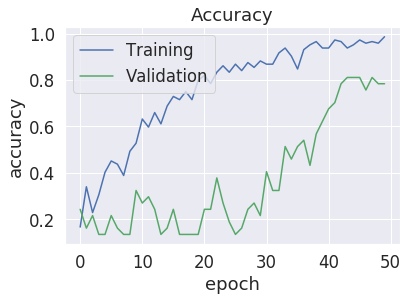

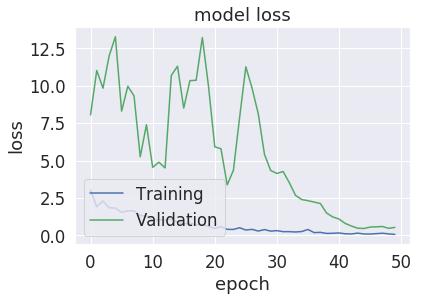

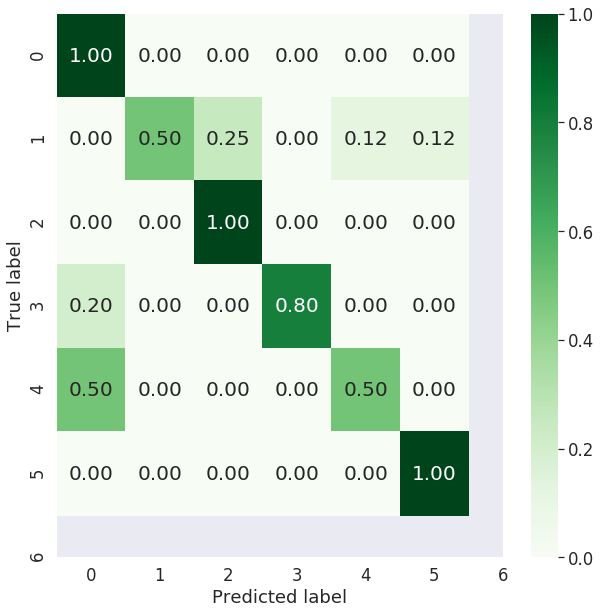

In [35]:
eval_model(cnn_history, cnn_model)

1/1 [==============================] - 0s 6ms/step
Evaluation loss:  0.4122045934200287
Evaluation accuracy:  0.837837815284729


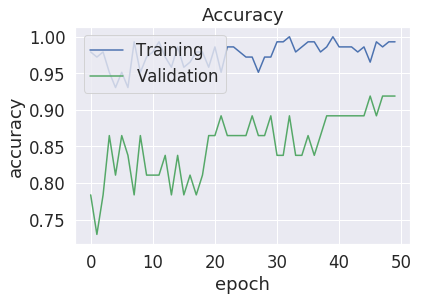

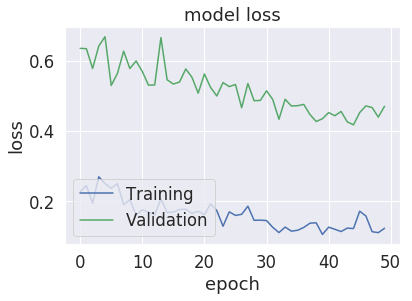

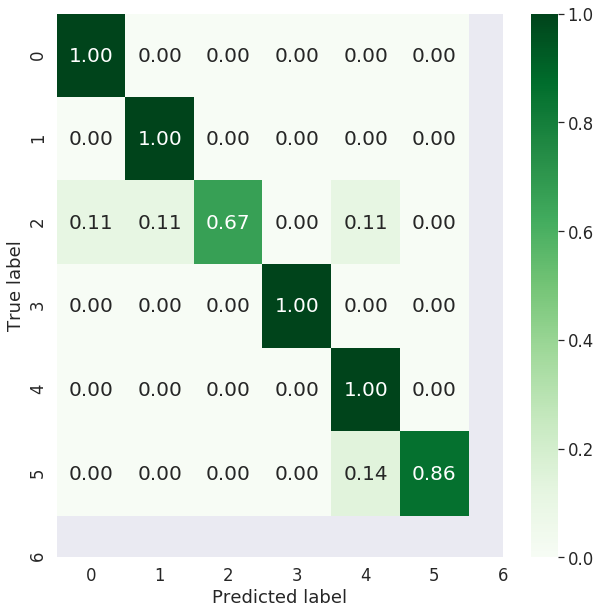

In [36]:
eval_model(nn_history, nn_model)